In [1]:
import numpy as np
import os
import re
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as plt_colors
import tensorflow as tf
import tensorflow.keras as keras
from tensorboard.plugins import projector
import sys
from PIL import Image

import smfret.fit as fit
import smfret.finetuning as finetuning

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import MultistepPhotobleachingTraceSet
from smfret.multi_task_learning import NoiseLevelTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTrace
from smfret.dataset import FRETTraceSet

from smfret.multi_task_learning import SavedTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import mixture

from enum import Enum
import json
import umap
import scipy

from sciplotlib import style as spstyle
from tqdm.auto import tqdm

/Users/leyou/miniforge3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leyou/miniforge3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leyou/miniforge3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWa

In [2]:
NN_K = 50  # how many nearest neighbors are considered for the score
def calculate_distance(embedding):
    """Calculates the distance matrix from the embeddings."""
    distance = (
        tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=-1)
        + tf.expand_dims(tf.einsum('ik,ik->i', embedding, embedding), axis=0)
        - 2.0 * tf.einsum('ik,jk->ij', embedding, embedding))
    return distance

def get_perplexity(embedding, label, branching_factor, use_excess_definition=True, normalize=True):
    """Calculates the perplexity of a trace's neighbors.""" 
    distance = calculate_distance(embedding)
    top_k_results = tf.math.top_k(
        -distance, k=branching_factor + 1, sorted=True, name=None
    )
    top_k_idx = top_k_results.indices.numpy()
    n = embedding.shape[0]
    perplexity = []
    for i in range(n):
        this_label = label[i]
        neighbour_label = label[top_k_idx[i, :].flatten()]
        unique_labels = set(neighbour_label)
        shannon_entropy = 0
        for l in unique_labels:
            p = np.mean(neighbour_label == l)
            shannon_entropy -= p * np.log(p)
        perplexity.append(shannon_entropy)
    return np.array(perplexity)

In [3]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')
encoder = keras.models.load_model('../../saved_models/best_model/encoder-20240111-045226.h5', compile=False)

In [4]:
def read_simcan_tracesets(file, label=None, start_frame=0, max_frames=8000):
    """Converts .MAT data into model-compatible trace sets."""
    key = 'data'
    conv_width = 100
    dialation_factor = 1
    simcan_data = scipy.io.loadmat(file)[key][0]
    trace_sets = []
    labels = []
    for data in simcan_data:
        label = data[0][0][0][0]
        donor = data[0][0][2][:, 1]
        acceptor = data[0][0][2][:, 2]
        trace_set = FRETTraceSet()
        trace_set.donor = np.expand_dims(donor, axis=0)
        trace_set.acceptor = np.expand_dims(acceptor, axis=0)
        trace_set.time = np.arange(len(donor)) + 1
        trace_set.size = 1
        trace_set.label = tf.zeros_like(trace_set.donor)
        if len(donor) >= 100:
            trace_sets.append(trace_set)
            labels.append(label)
    return trace_sets, labels

In [5]:
trace_sets, labels = read_simcan_tracesets('../../saved_dataset/downstream/SiMCAn/converted_all_data.mat')

In [6]:
print(f"There are {len(trace_sets)} traces in the dataset.")

There are 6805 traces in the dataset.


In [7]:
# Export to the embedding projector

def trim(x, precision=4):
    """Trims a float to a given precision."""
    if int(x) == x:
        return x
    else:
        return float(np.format_float_positional(x, precision=4, unique=False, fractional=False, trim='k'))

def generate_projector_data(log_dir, embedding, trace_set, plot_label, predicted_label, k_means_label, sprite=False):
    Path(log_dir).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
      f.write('name\tground truth\tpredicted label\tk-means-clustering\tdonor\tacceptor\n')
      for index in range(embedding.shape[0]):
        donor = np.array([trim(x) for x in trace_set.traces[index].donor])
        acceptor = np.array([trim(x) for x in trace_set.traces[index].acceptor])
        f.write(f"trace {index}\t{plot_label[index]}\t{predicted_label[index]}\t{k_means_label[index]}\t{json.dumps(donor.tolist())}\t{json.dumps(acceptor.tolist())}\n")
    with open(log_dir + 'tensor.bytes', 'wb') as f:
        f.write(np.array(tf.cast(embedding, tf.float32)).tobytes())
    np.savetxt(log_dir + 'tensor.tsv', embedding, delimiter='\t')

def generate_tensor_and_metadata(trace_sets, start_frame, output_dir, encoder, reducer, max_size=4000, max_frame=2000, balance_label=True, logistic_regression=True, class_weight=None):
    """Generates the files for embedding projector."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 100 * 100
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        print(trace_set.size)
        if balance_label:
          size = 2 * np.sum(np.max(trace_set.label, axis=-1))
        else:
          size = trace_set.size
        if count + size > max_size:
            break
        else:
            count += size
                
        with tf.device('/CPU:0'):
            embedding = reducer.transform(encoder.predict(trace_set.to_tensor()))
            embeddings.append(embedding)
            labels.append(np.max(trace_set.label, axis=-1))
            traces.extend(trace_set.traces)
    
    labels = np.concatenate(labels, axis=0)
    n_included = np.sum(labels == 1)
    n_excluded = np.sum(labels == 0)

    indices = np.arange(len(labels))
    if balance_label:
      ratio = int(n_excluded / n_included)
      if ratio > 1:
        indices = np.concatenate([indices[labels == 1], indices[labels ==0][::ratio]])
        labels = labels[indices]
    
    trace_set = FRETTraceSet()
    trace_set.traces = [traces[i] for i in indices]
    trace_set.size = len(trace_set.traces)
    embedding = np.concatenate(embeddings, axis=0)[indices, :]
    if np.max(labels) == 1:
        labels = np.where(labels == 1, 'Included in Analysis', 'Excluded from Analysis')
    kmeans_labels = cluster.KMeans(n_clusters=2).fit_predict(embedding)
    clf = LogisticRegression(random_state=0, max_iter=5000, class_weight=class_weight).fit(embedding, labels)
    predicted_label = clf.predict(embedding)
    # kmeans_labels = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True).fit_predict(clusterable_embedding)
    generate_projector_data(output_dir, embedding, trace_set, labels, predicted_label, kmeans_labels, sprite=False)

In [8]:
def generate_embedding_and_label(trace_sets, start_frame, encoder, max_frame=2000, max_traces=4000, balance_labels=True):
    """Generates the embeddings and labels."""

    embeddings = []
    labels = []
    colors = []
    color_count = 1
    image_files = []
    traces = []
    
    count = 0
    for trace_set in trace_sets:
        trim_size = len(trace_set.time) // 100 * 100
        trace_set.trim(trim_size)
        trace_set.trim(max_frame, start_frame=start_frame)
        trace_set.broadcast_data_to_traces()
        if count + trace_set.size > max_traces:
            break
        else:
            count += trace_set.size
                
        with tf.device('/CPU:0'):
            label = np.max(trace_set.label, axis=-1)
            if balance_labels:
                n_included = np.sum(label == 1)
                n_excluded = np.sum(label == 0)
                if n_included == 0 or n_excluded == 0:
                    continue
                indices = np.arange(len(label))
                ratio = int(n_excluded / n_included)
                # ratio = 0
                if ratio > 1:
                    indices = np.concatenate([indices[label == 1], indices[label ==0][::ratio]])
                    label = label[indices]
                    trace_set = trace_set.get_subset(indices)

            embedding = encoder.predict(trace_set.to_tensor(), batch_size=8, verbose=0)
            embeddings.append(embedding)
            labels.append(label)
            traces.extend(trace_set.traces)
    return embeddings, labels

In [9]:
embeddings_spot, labels_spot = generate_embedding_and_label(trace_sets, 0, encoder, max_frame=2000, max_traces=20000, balance_labels=False)

In [10]:
final_embeddings = []
final_labels = []
human_labels = []
for e, l in zip(embeddings_spot, labels_spot):
    final_embeddings.append(e)
    final_labels.append(l)
embedding_spot = np.concatenate(final_embeddings, axis=0)
human_label_spot = np.concatenate(final_labels)
label_spot = np.array(labels)

In [13]:
new_label_spot = np.array([l.replace('Late', '').replace('Middle', '').replace('Early', '').replace('Mid', '').replace('early', '') for l in label_spot])

In [14]:
sorted(list(set(new_label_spot.tolist())))

['ATP3SScompiled',
 'NoATPcompiled',
 'Prp16DN3SS',
 'Prp16DNWT',
 'Prp2dep3SScompiled',
 'Prp2depWTcompiled',
 'U6depCompiled',
 'WTATPcompiled']

In [15]:
ordered_label_spot = [
    'NoATPcompiled',
    'U6depCompiled',
    'Prp2depWTcompiled',
    'Prp2dep3SScompiled',
    'Prp16DNWT',
    'Prp16DN3SS',
    'ATP3SScompiled',
    'WTATPcompiled',
]

In [16]:
perplexity_spot = get_perplexity(embedding_spot, new_label_spot, branching_factor=50)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


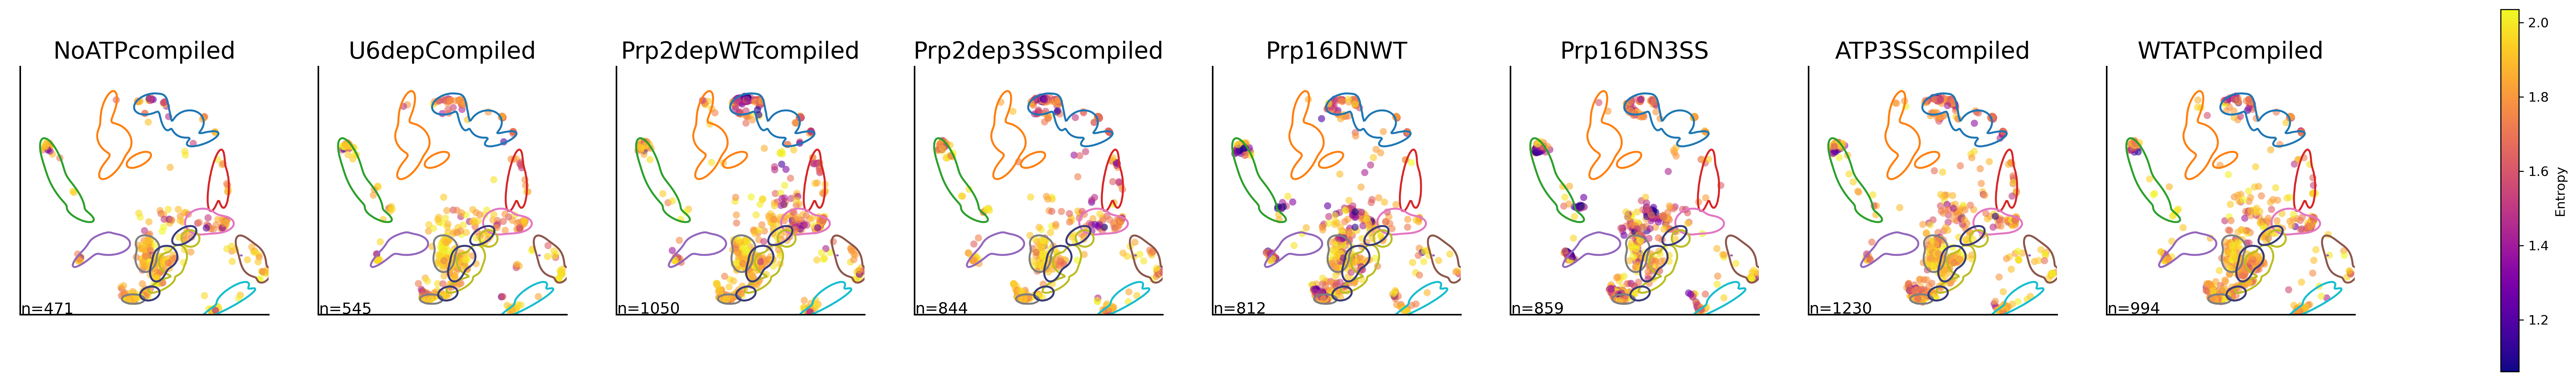

In [17]:
reducer = joblib.load('../../saved_models/UMAP/atlas_pp.joblib')
saved_atlas_density_models = joblib.load('../../saved_models/UMAP/atlas_pp_density_models.joblib')
n = len(set(label_spot.tolist()))

cutoff = np.quantile(perplexity_spot, 1.0)
counter = 0

z_h = reducer.transform(embedding_spot)
ax_min = np.min(z_h)
ax_max = np.max(z_h)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(ncols=len(ordered_label_spot), nrows=1, figsize=(5 * len(ordered_label_spot), 5));
for l in ordered_label_spot:
    idx = (new_label_spot == l) & (perplexity_spot <= cutoff)
    z = z_h[idx, ...]
    with plt.style.context(spstyle.get_style('nature-reviews')):
        ax = axes[counter]
        counter += 1
        s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=30, alpha=0.6, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ax_min, ax_max])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(f'{l}')
        ax.text(x=ax.get_xlim()[0]+ 0.1, y=ax.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 12})

    contour_counter = 0
    for l in saved_atlas_density_models:
        color = plt.cm.tab20.colors + plt.cm.tab20b.colors[::2]
        x = np.linspace(np.min(z_h[:, 0]) - 1, np.max(z_h[:, 0]) + 1, num=200)
        y = np.linspace(np.min(z_h[:, 1]) - 1, np.max(z_h[:, 1]) + 1, num=200)
        X, Y = np.meshgrid(x, y)
        clf = saved_atlas_density_models[l]
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = clf.score_samples(XX)
        Z = np.exp(Z.reshape(X.shape))
        cmap = plt_colors.LinearSegmentedColormap.from_list("", [color[contour_counter], color[contour_counter], color[contour_counter]])
        if 'n' not in l:
            CS = ax.contour(
                X, Y, Z, cmap=cmap, levels=[1e-2]
            )
        contour_counter += 1

color_bar = fig.colorbar(s, ax=axes, label="Entropy")
color_bar.set_alpha(1)
color_bar.draw_all()
if cutoff >= np.quantile(perplexity_spot, 0.9):
    plt.savefig('figures/simcan_perplexity_umap_atlas.svg')
else:
    plt.savefig('figures/simcan_perplexity_umap_atlas_threshold.svg')
plt.show()

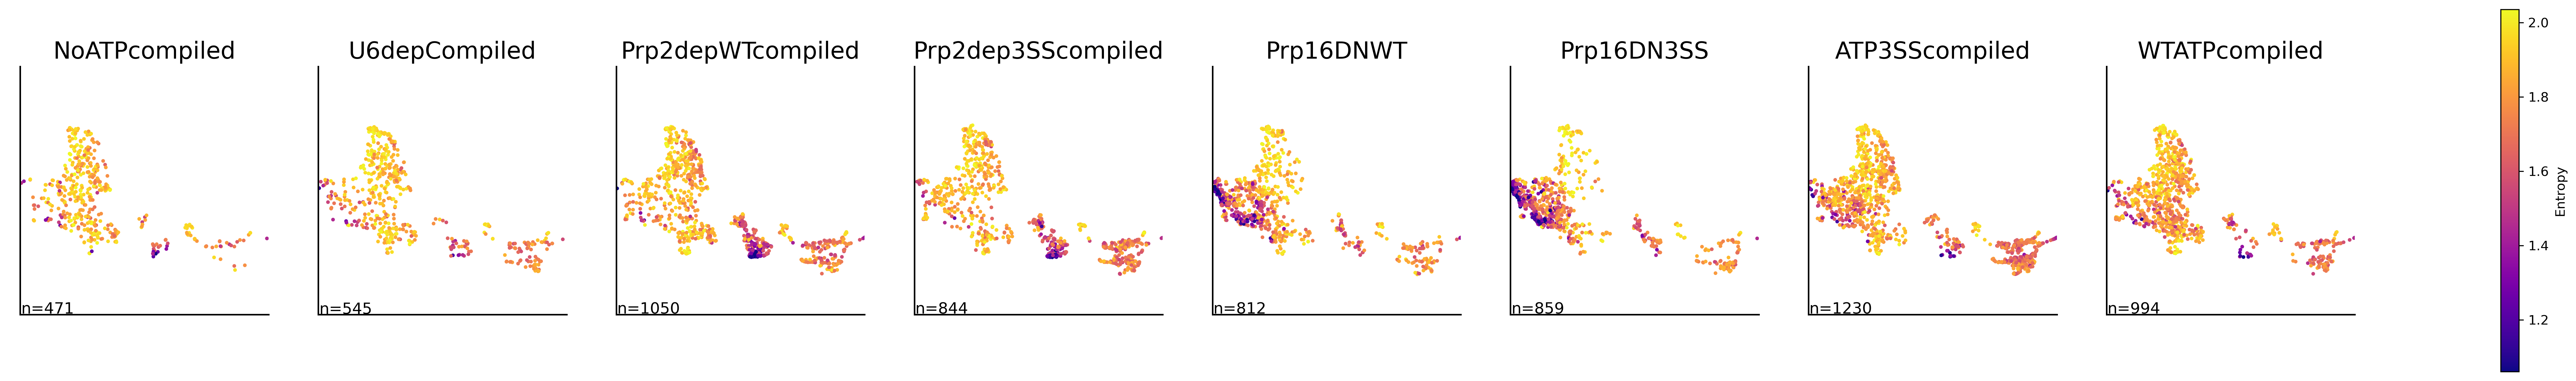

In [18]:
reducer = umap.UMAP(n_epochs=500, n_neighbors=30, min_dist=0.0, random_state=np.random.RandomState(60), n_components=2, negative_sample_rate=15)
reducer.fit_transform(embedding_spot)

n = len(set(label_spot.tolist()))
counter = 0

z_h = reducer.transform(embedding_spot)
ax_min = np.min(z_h)
ax_max = np.max(z_h)
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(ncols=len(ordered_label_spot), nrows=1, figsize=(5 * len(ordered_label_spot), 5));
for l in ordered_label_spot:
    idx = (new_label_spot == l) & (perplexity_spot <= cutoff)
    z = z_h[idx, ...]
    with plt.style.context(spstyle.get_style('nature-reviews')):
        ax = axes[counter]
        counter += 1
        if cutoff >= np.quantile(perplexity_spot, 0.9):
            s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=8, alpha=1, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        else:
            s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=30, alpha=0.5, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        # s = ax.scatter(z[:, 0], z[:, 1], c=perplexity_spot[idx], s=30, alpha=.5, linewidths=0, cmap='plasma', vmin=np.quantile(perplexity_spot, 0.01), vmax=np.quantile(perplexity_spot, 0.99))
        ax.set_xlim([ax_min, ax_max])
        ax.set_ylim([ax_min, ax_max])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(f'{l}')
        ax.text(x=ax.get_xlim()[0]+ 0.1, y=ax.get_ylim()[0] + 0.1, s=f'n={z.shape[0]}', fontdict={'size': 12})
color_bar = fig.colorbar(s, ax=axes, label="Entropy")
color_bar.set_alpha(1)
color_bar.draw_all()
if cutoff >= np.quantile(perplexity_spot, 0.9):
    plt.savefig('figures/simcan_perplexity_umap.svg')
else:
    plt.savefig('figures/simcan_perplexity_umap_threshold.svg')
plt.show()